<a href="https://colab.research.google.com/github/marisbotero/sapiencia/blob/main/Final_workshop_MarisBotero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Context

Customer segmentation is the practice of dividing a customer base into groups of individuals that are similar in specific ways relevant to marketing, such as age, gender, interests and spending habits.

Companies employing customer segmentation operate under the fact that every customer is different and that their marketing efforts would be better served if they target specific, smaller groups with messages that those consumers would find relevant and lead them to buy something. Companies also hope to gain a deeper understanding of their customers' preferences and needs with the idea of discovering what each segment finds most valuable to more accurately tailor marketing materials toward that segment.


#### Variable description:

- CustomerID : unique customer ID
- Gender : gender of the customer
- Married : marital status of the customer
- Age : age of the customer
- Graduated : specifies whether the customer a graduate?
- Profession : profession of the customer
- WorkExperience : work experience of the customer in years
- SpendingScore : spending score of the customer
- FamilySize : number of family members of the customer (including the customer)
- Category : anonymised category for the customer

# Activity

1. Review data quality issues and perform transformations if necessary

* Revisar problemas de calidad de datos y realizar transformaciones si es necesario

2. Divide the dataset into 4 customer segments, testing at least two algorithms and choosing the one with the best Sillouhette score.

* Dividir el dataset en 4 segmentos de clientes, probando al menos dos algoritmos de clustering y elegir el que mejor Indice de Sillouhette tenga.

3. Carry out an EDA (Exploratory Data Analysis) of each of the clusters to pass the report to the management with the conclusion of what type of car should be promoted to each of the segments and what benefit or strategy they should use to advertise it.

* Realizar un EDA (Exploratory Data Analysis) de cada uno de los clusters para pasar el informe a la gerencia con la conclusión de qué tipo de auto debe promocionarse a cada uno de los segmentos y que beneficio o estrategia deberían usar para publicitarlo.


In [6]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
import seaborn as sns
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [7]:
#cargar los datos
df = pd.read_csv('final-workshop-train.xls')

In [8]:
df.head()

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Category 4
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Category 4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Category 6
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Category 6
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Category 6


In [9]:
#función para revisar los valores nulos
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [10]:
missing_percentage(df)

,Total,Percent
WorkExperience,829,10.28
FamilySize,335,4.15
Married,140,1.74
Profession,124,1.54
Graduated,78,0.97
Category,76,0.94
SpendingScore,0,0.00
Age,0,0.00
Gender,0,0.00
CustomerID,0,0.00


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,8068.0,463479.214551,2595.381232,458982.0,461240.75,463472.5,465744.25,467974.0
Age,8068.0,43.466906,16.711696,18.0,30.00,40.0,53.00,89.0
WorkExperience,7239.0,2.641663,3.406763,0.0,0.00,1.0,4.00,14.0
FamilySize,7733.0,2.850123,1.531413,1.0,2.00,3.0,4.00,9.0


In [12]:
df['FamilySize'].median()

3.0

In [13]:
df['WorkExperience'].median()

1.0

In [14]:
df2 = df

In [15]:
#Missing values
df2["WorkExperience"] = df2["WorkExperience"].fillna(1)
df2["FamilySize"] = df2["FamilySize"].fillna(3)
df2['Married'] = df2['Married'].dropna()
df2['Profession'] = df2['Profession'].dropna()
df2['Graduated'] = df2['Graduated'].dropna()
#df2['Category'] = df2['Category'].fillna('Desconocido')

In [16]:
#revisar los datos, cantidad y tipo de datos
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      8068 non-null   int64  
 1   Gender          8068 non-null   object 
 2   Married         7928 non-null   object 
 3   Age             8068 non-null   int64  
 4   Graduated       7990 non-null   object 
 5   Profession      7944 non-null   object 
 6   WorkExperience  8068 non-null   float64
 7   SpendingScore   8068 non-null   object 
 8   FamilySize      8068 non-null   float64
 9   Category        7992 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 630.4+ KB


In [17]:
#convertir campo FamilySize a enetero
df2['FamilySize'] = df['FamilySize'].astype(int)

In [18]:
#convertir campo workExperiencie a enetero
df2['WorkExperience'] = df['WorkExperience'].astype(int)

In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      8068 non-null   int64 
 1   Gender          8068 non-null   object
 2   Married         7928 non-null   object
 3   Age             8068 non-null   int64 
 4   Graduated       7990 non-null   object
 5   Profession      7944 non-null   object
 6   WorkExperience  8068 non-null   int64 
 7   SpendingScore   8068 non-null   object
 8   FamilySize      8068 non-null   int64 
 9   Category        7992 non-null   object
dtypes: int64(4), object(6)
memory usage: 630.4+ KB


Análisis de las variables

In [20]:
df2['Gender'].value_counts()

Male      4417
Female    3651
Name: Gender, dtype: int64

In [21]:
df2['Married'].value_counts()

Yes    4643
No     3285
Name: Married, dtype: int64

In [22]:
df2['Graduated'].value_counts()

Yes    4968
No     3022
Name: Graduated, dtype: int64

In [23]:
df2['Profession'].value_counts()

Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: Profession, dtype: int64

In [24]:
df2['WorkExperience'].value_counts()

1     3183
0     2318
9      474
8      463
2      286
3      255
4      253
6      204
7      196
5      194
10      53
11      50
12      48
13      46
14      45
Name: WorkExperience, dtype: int64

In [25]:
df2['SpendingScore'].value_counts()

Low        4878
Average    1974
High       1216
Name: SpendingScore, dtype: int64

In [26]:
df2['FamilySize'].value_counts()

2    2390
3    1832
1    1453
4    1379
5     612
6     212
7      96
8      50
9      44
Name: FamilySize, dtype: int64

In [27]:
df2['Category'].value_counts()

Category 6    5238
Category 4    1089
Category 3     822
Category 2     422
Category 7     203
Category 1     133
Category 5      85
Name: Category, dtype: int64

In [28]:
df2.columns

Index(['CustomerID', 'Gender', 'Married', 'Age', 'Graduated', 'Profession',
       'WorkExperience', 'SpendingScore', 'FamilySize', 'Category'],
      dtype='object')

In [29]:
a =['Gender','Married','Age','Graduated','Profession','WorkExperience','SpendingScore','FamilySize']

In [30]:
data = df2[a]

In [31]:
data.head(10)

,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize
0,Male,No,22,No,Healthcare,1,Low,4
1,Female,Yes,38,Yes,Engineer,1,Average,3
2,Female,Yes,67,Yes,Engineer,1,Low,1
3,Male,Yes,67,Yes,Lawyer,0,High,2
4,Female,Yes,40,Yes,Entertainment,1,High,6
5,Male,Yes,56,No,Artist,0,Average,2
6,Male,No,32,Yes,Healthcare,1,Low,3
7,Female,No,33,Yes,Healthcare,1,Low,3
8,Female,Yes,61,Yes,Engineer,0,Low,3
9,Female,Yes,55,Yes,Artist,1,Average,4


## Análisis univariado
- variables categóricas

In [32]:
#función para graficar variables categoricas
def bar_plot(variable):
    """
        input: variable ex: "Pclass"
        output: bar plot & value count
    """
    # get feature
    var = data[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()
    
    # visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

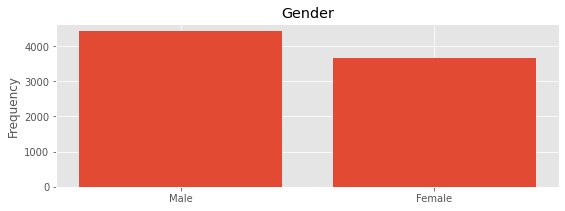

Gender: 
 Male      4417
Female    3651
Name: Gender, dtype: int64


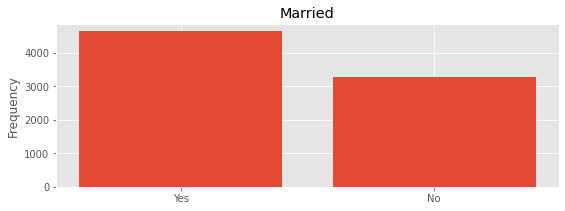

Married: 
 Yes    4643
No     3285
Name: Married, dtype: int64


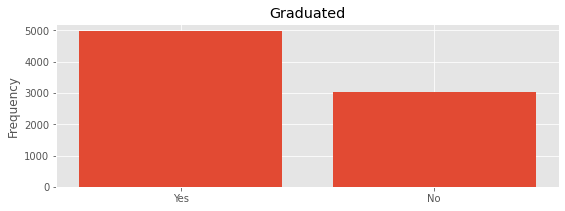

Graduated: 
 Yes    4968
No     3022
Name: Graduated, dtype: int64


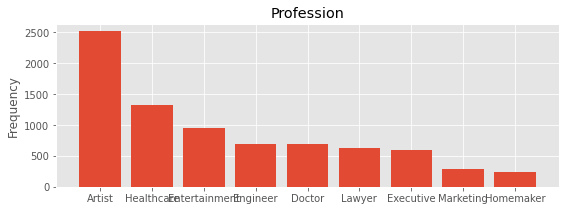

Profession: 
 Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: Profession, dtype: int64


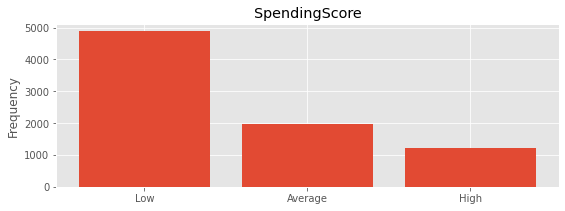

SpendingScore: 
 Low        4878
Average    1974
High       1216
Name: SpendingScore, dtype: int64


In [33]:
category1 = ["Gender","Married","Graduated","Profession","SpendingScore"]
for c in category1:
    bar_plot(c)

In [34]:
#función para graficar varibales numericas
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(data[variable], bins = 50)
    plt.xlabel(variable)
    plt.ylabel("Frecuancia")
    plt.title("{} Distribución".format(variable))
    plt.show()

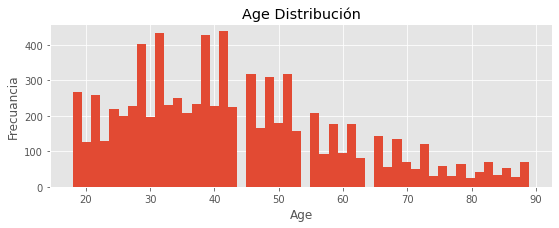

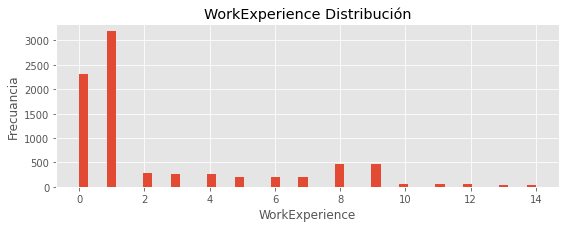

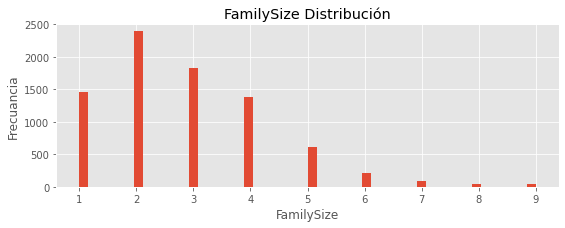

In [35]:
numericVar = ["Age", "WorkExperience" ,"FamilySize"]
for n in numericVar:
    plot_hist(n)

In [36]:
data.head()

,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize
0,Male,No,22,No,Healthcare,1,Low,4
1,Female,Yes,38,Yes,Engineer,1,Average,3
2,Female,Yes,67,Yes,Engineer,1,Low,1
3,Male,Yes,67,Yes,Lawyer,0,High,2
4,Female,Yes,40,Yes,Entertainment,1,High,6


In [37]:
data.columns

Index(['Gender', 'Married', 'Age', 'Graduated', 'Profession', 'WorkExperience',
       'SpendingScore', 'FamilySize'],
      dtype='object')

In [38]:
data['SpendingScore'].value_counts()

Low        4878
Average    1974
High       1216
Name: SpendingScore, dtype: int64

In [39]:
one_hot_encoded_data = pd.get_dummies(data, columns = ["Gender","Married","Graduated","Profession",'SpendingScore'])
one_hot_encoded_data

,Age,WorkExperience,FamilySize,Gender_Female,Gender_Male,Married_No,Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,SpendingScore_Average,SpendingScore_High,SpendingScore_Low
0,22,1,4,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1,38,1,3,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0
2,67,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,67,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,40,1,6,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,22,0,7,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
8064,35,3,4,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
8065,33,1,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
8066,27,1,4,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [40]:
one_hot_encoded_data.columns

Index(['Age', 'WorkExperience', 'FamilySize', 'Gender_Female', 'Gender_Male',
       'Married_No', 'Married_Yes', 'Graduated_No', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'SpendingScore_Average', 'SpendingScore_High',
       'SpendingScore_Low'],
      dtype='object')

In [41]:
b =['Age', 'WorkExperience', 'FamilySize','Gender_Male',
       'Married_Yes', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing','SpendingScore_Average', 'SpendingScore_High',
       'SpendingScore_Low']
datos = one_hot_encoded_data[b] 
datos.head()

,Age,WorkExperience,FamilySize,Gender_Male,Married_Yes,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,SpendingScore_Average,SpendingScore_High,SpendingScore_Low
0,22,1,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,38,1,3,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0
2,67,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1
3,67,0,2,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0
4,40,1,6,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0


Normalización de los datos

In [42]:
# Escalado de las variables
# ==============================================================================

datos_scaled = (datos-datos.min())/(datos.max()-datos.min())
datos_scaled.head()

,Age,WorkExperience,FamilySize,Gender_Male,Married_Yes,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,SpendingScore_Average,SpendingScore_High,SpendingScore_Low
0,0.056338,0.071429,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.281690,0.071429,0.250,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.690141,0.071429,0.000,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.690141,0.000000,0.125,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.309859,0.071429,0.625,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Distancias

In [43]:
# Cálculo de distancias
# ==============================================================================
print('------------------')
print('Distancia euclídea')
print('------------------')
distancias = pairwise_distances(
                X      = datos_scaled,
                metric ='euclidean'
             )

# Se descarta la diagonal superior de la matriz
distancias[np.triu_indices(n=distancias.shape[0])] = np.nan

distancias = pd.DataFrame(
                distancias,
                columns=datos_scaled.index,
                index = datos_scaled.index
            )

distancias.iloc[:4,:4]

------------------
Distancia euclídea
------------------


,0,1,2,3
0,NaN,NaN,NaN,NaN
1,2.658272,NaN,NaN,NaN
2,2.354216,1.493095,NaN,NaN
3,2.543483,2.277621,2.240698,NaN


In [44]:
# Top n observaciones más similares
# ==============================================================================
distancias.melt(ignore_index=False, var_name="estado_b", value_name='distancia') \
    .rename_axis("estado_a") \
    .reset_index() \
    .dropna() \
    .sort_values('distancia') \
    .head(3)

,estado_a,estado_b,distancia
17804907,6899,2206,0.0
22990195,4463,2849,0.0
18391324,4352,2279,0.0


## K-means

In [45]:
# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

In [46]:
model = KMeans(n_clusters=4)
model.fit(datos_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [47]:
model.labels_

array([1, 0, 3, ..., 1, 1, 0], dtype=int32)

In [48]:
md_k = pd.Series(model.labels_)

In [49]:
datos_scaled["clust_k"] = md_k

In [50]:
datos_scaled.head()

,Age,WorkExperience,FamilySize,Gender_Male,Married_Yes,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,SpendingScore_Average,SpendingScore_High,SpendingScore_Low,clust_k
0,0.056338,0.071429,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,0.281690,0.071429,0.250,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.690141,0.071429,0.000,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
3,0.690141,0.000000,0.125,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2
4,0.309859,0.071429,0.625,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2


(array([1972.,    0.,    0., 1990.,    0.,    0., 1212.,    0.,    0.,
        2894.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

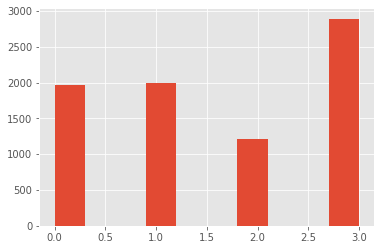

In [51]:
plt.hist(md_k)

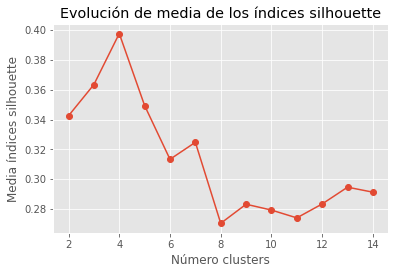

In [52]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(datos_scaled)
    silhouette_avg = silhouette_score(datos_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

## Clustering jerárquico con scikit-learn

In [53]:
from sklearn.cluster import AgglomerativeClustering

In [54]:
clus= AgglomerativeClustering(n_clusters=4, linkage="ward").fit(datos_scaled)

In [55]:
md_h = pd.Series(clus.labels_)

Text(0.5, 0, 'Cluster')

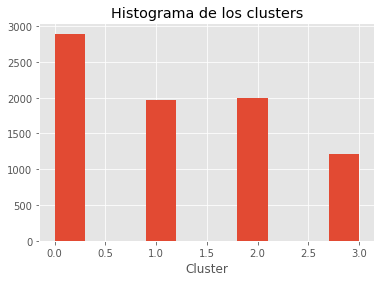

In [56]:
plt.hist(md_h)
plt.title("Histograma de los clusters")
plt.xlabel("Cluster")

In [57]:
datos_scaled.head()

,Age,WorkExperience,FamilySize,Gender_Male,Married_Yes,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,SpendingScore_Average,SpendingScore_High,SpendingScore_Low,clust_k
0,0.056338,0.071429,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,0.281690,0.071429,0.250,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.690141,0.071429,0.000,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
3,0.690141,0.000000,0.125,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2
4,0.309859,0.071429,0.625,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2


In [58]:
clus.children_

array([[    0,   968],
       [    2,  6651],
       [    3,  5596],
       ...,
       [16128, 16131],
       [16129, 16130],
       [16132, 16133]])

In [59]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [60]:
Z = linkage(datos_scaled, "ward")

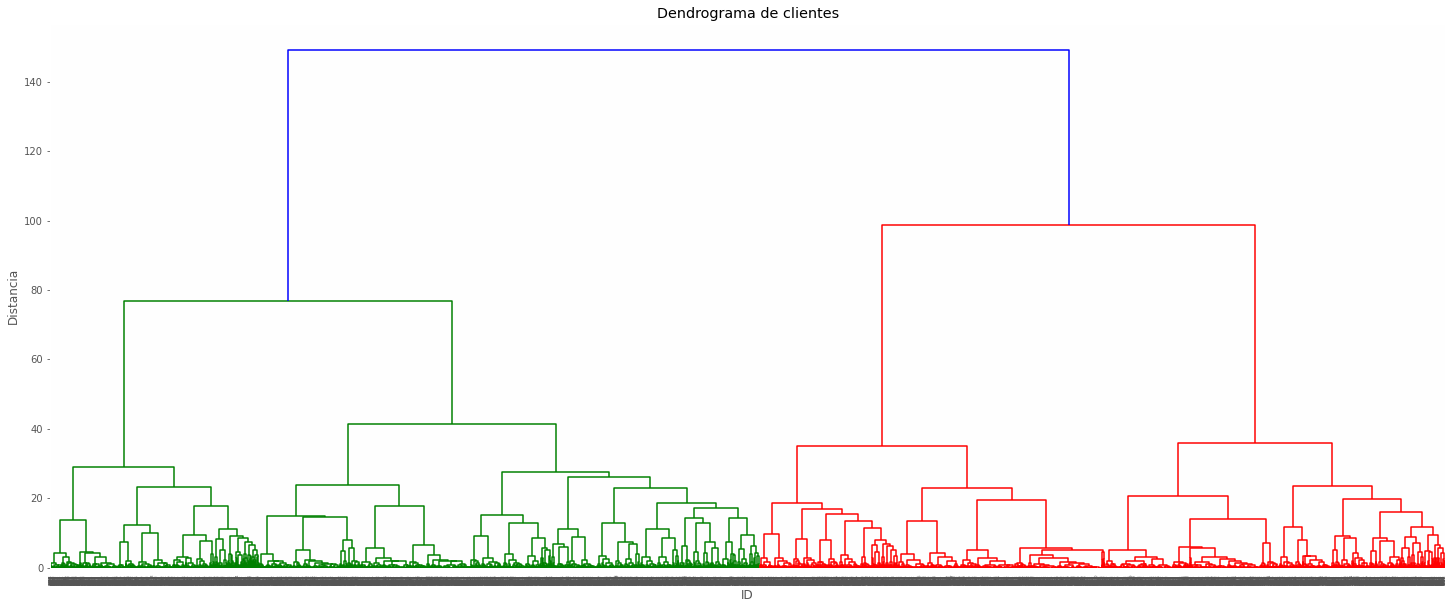

In [61]:
plt.figure(figsize=(25,10))
plt.title("Dendrograma de clientes")
plt.xlabel("ID")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=90., leaf_font_size=4.)
plt.show()

In [62]:
datos_scaled["clust_h"] = md_h

In [63]:
datos_scaled.head()

,Age,WorkExperience,FamilySize,Gender_Male,Married_Yes,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,SpendingScore_Average,SpendingScore_High,SpendingScore_Low,clust_k,clust_h
0,0.056338,0.071429,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,2
1,0.281690,0.071429,0.250,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
2,0.690141,0.071429,0.000,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,0
3,0.690141,0.000000,0.125,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2,3
4,0.309859,0.071429,0.625,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,3


In [64]:
model.cluster_centers_

array([[ 4.06786561e-01,  1.68465662e-01,  2.62994422e-01,
         5.79614604e-01,  9.82251521e-01,  7.35294118e-01,
         5.12677485e-01,  8.97565923e-02,  1.12068966e-01,
         1.61764706e-01,  3.80324544e-02,  2.02839757e-02,
         3.04259635e-02,  9.12778905e-03,  8.62068966e-03,
         1.00000000e+00,  2.96984659e-15, -2.12052598e-14],
       [ 1.37594256e-01,  1.77800874e-01,  3.17423482e-01,
         5.13296538e-01,  5.01756147e-03,  1.81133969e-01,
         2.35825389e-02,  9.43301555e-02,  7.37581535e-02,
         7.32563974e-02,  1.25439037e-02,  5.99598595e-01,
         3.41194180e-02,  8.02809834e-03,  6.27195183e-02,
         1.00351229e-03,  2.00702459e-03,  9.96989463e-01],
       [ 5.61892809e-01,  1.40205092e-01,  2.48349835e-01,
         5.96534653e-01,  9.70297030e-01,  6.43564356e-01,
         1.99669967e-01,  2.55775578e-02,  4.95049505e-02,
         3.79537954e-02,  3.28382838e-01,  3.38283828e-02,
         2.14521452e-02,  2.67326733e-01,  2.72277228e

In [65]:
model.inertia_

10771.774723186745

In [66]:
datos_scaled.groupby("clust_k").mean()

,Age,WorkExperience,FamilySize,Gender_Male,Married_Yes,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,SpendingScore_Average,SpendingScore_High,SpendingScore_Low,clust_h
clust_k,,,,,,,,,,,,,,,,,,,
0,0.406787,0.168466,0.262994,0.579615,0.982252,0.735294,0.512677,0.089757,0.112069,0.161765,0.038032,0.020284,0.030426,0.009128,0.008621,1.000000,0.00000,0.000000,1
1,0.137469,0.177782,0.317525,0.513065,0.005025,0.181407,0.022111,0.094472,0.073869,0.073367,0.012563,0.600503,0.034171,0.008040,0.062814,0.001005,0.00201,0.996985,2
2,0.561893,0.140205,0.248350,0.596535,0.970297,0.643564,0.199670,0.025578,0.049505,0.037954,0.328383,0.033828,0.021452,0.267327,0.027228,0.000000,1.00000,0.000000,3
3,0.392930,0.196688,0.145344,0.528680,0.525225,0.821355,0.421216,0.100898,0.093642,0.151348,0.034900,0.019350,0.031790,0.091569,0.040428,0.000000,0.00000,1.000000,0


In [67]:
datos_scaled.groupby("clust_h").mean()

,Age,WorkExperience,FamilySize,Gender_Male,Married_Yes,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,SpendingScore_Average,SpendingScore_High,SpendingScore_Low,clust_k
clust_h,,,,,,,,,,,,,,,,,,,
0,0.392930,0.196688,0.145344,0.528680,0.525225,0.821355,0.421216,0.100898,0.093642,0.151348,0.034900,0.019350,0.031790,0.091569,0.040428,0.000000,0.00000,1.000000,3
1,0.406787,0.168466,0.262994,0.579615,0.982252,0.735294,0.512677,0.089757,0.112069,0.161765,0.038032,0.020284,0.030426,0.009128,0.008621,1.000000,0.00000,0.000000,0
2,0.137469,0.177782,0.317525,0.513065,0.005025,0.181407,0.022111,0.094472,0.073869,0.073367,0.012563,0.600503,0.034171,0.008040,0.062814,0.001005,0.00201,0.996985,1
3,0.561893,0.140205,0.248350,0.596535,0.970297,0.643564,0.199670,0.025578,0.049505,0.037954,0.328383,0.033828,0.021452,0.267327,0.027228,0.000000,1.00000,0.000000,2
